# 0. 데이터 로드

In [3]:
import pandas as pd


total_data = pd.read_csv('preprocessing1_data.csv')
total_data['preprocessed'] = total_data['preprocessed'].apply(lambda x: str(x).split())

313471
   label   count
0      0  128187
1      1  185284


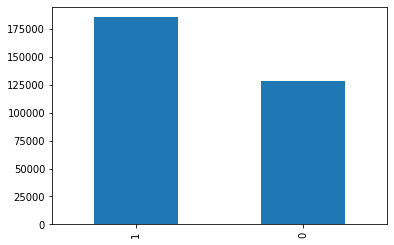

In [4]:
import matplotlib.pyplot as plt


total_data['label'].value_counts().plot(kind = 'bar')
print(len(total_data))
print(total_data.groupby('label').size().reset_index(name = 'count'))

# 1. 데이터 분리

In [6]:
from sklearn.model_selection import train_test_split


train_data, test_data = train_test_split(total_data, test_size = 0.2, random_state = 42)

X_train = train_data['preprocessed'].values
y_train = train_data['label'].values

X_test = test_data['preprocessed'].values
y_test = test_data['label'].values

250776
   label   count
0      0  102556
1      1  148220


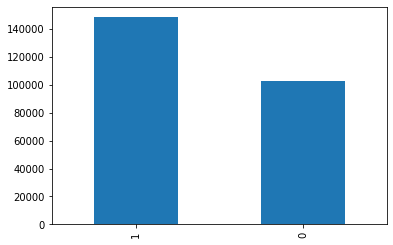

In [7]:
train_data['label'].value_counts().plot(kind = 'bar')
print(len(train_data))
print(train_data.groupby('label').size().reset_index(name = 'count'))

# 2. 정수형 인코딩

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer


def above_threshold_freq(X_train, min_freq):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X_train)

    threshold = min_freq
    
    total_cnt = len(tokenizer.word_index)
    rare_cnt = 0
    total_freq = 0
    rare_freq = 0

    for key, value in tokenizer.word_counts.items():
        total_freq += value
        if(value < threshold):
            rare_cnt = rare_cnt + 1
            rare_freq = rare_freq + value

    print('단어 집합(vocabulary)의 크기 :',total_cnt)
    print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
    print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
    print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)
    

    vocab_size = total_cnt - rare_cnt + 2
    print('단어 집합의 크기 :',vocab_size)


    return vocab_size

In [9]:
min_freq = 3
vocab_size = above_threshold_freq(X_train, min_freq)

단어 집합(vocabulary)의 크기 : 54663
등장 빈도가 2번 이하인 희귀 단어의 수: 26810
단어 집합에서 희귀 단어의 비율: 49.04597259572289
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.0374138027520938
단어 집합의 크기 : 27855


In [ ]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# 3. 패팅

리뷰의 최대 길이 : 113
리뷰의 평균 길이 : 13.172051686699811


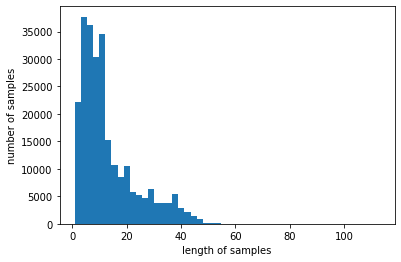

In [11]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [12]:
def below_threshold_len(X_train, max_len):
    cnt = 0
    for sent in X_train:
        if(len(sent) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(X_train))*100))

In [17]:
max_len = 60
below_threshold_len(X_train, max_len=max_len)

전체 샘플 중 길이가 60 이하인 샘플의 비율: 99.95649267692649


In [18]:
from tensorflow.keras.preprocessing.sequence import pad_sequences


X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

# 4. 학습

In [49]:
from gensim.models import FastText
ft = FastText(train_data['review'].values, size=256, window=2, min_count=1, workers=5, sg=1)

In [56]:
ft.shape()

AttributeError: 'FastText' object has no attribute 'shape'

In [51]:
import numpy as np

embedding_size = 256
embedding_matrix = np.zeros((vocab_size, embedding_size))

In [ ]:
for index, word in enumerate(vocabulary): #vocabulary에 있는 토큰들을 하나씩 넘겨줍니다.
    if word in word2vec: #넘겨 받은 토큰이 word2vec에 존재하면(이미 훈련이 된 토큰이라는 뜻)
        embedding_vector = word2vec[word] #해당 토큰에 해당하는 vector를 불러오고
        embedding_mxtrix[i] = embedding_vector #해당 위치의 embedding_mxtrix에 저장합니다.

In [46]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding, Dense, Dropout, GRU, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
from gensim.models.fasttext import FastText


embedding_size = 256
hidden_size = 128

model = Sequential()
model.add(Embedding(vocab_size, 300,weights = [embedding_matrx], input_length = max_len))
model.add(Dropout(0.5))
model.add(GRU(hidden_size))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint(
    f'./result/gru/f{min_freq}_l{max_len}_ft{embedding_size}_h{hidden_size}/best_model.h5', 
    monitor='val_acc', mode='max', verbose=1, save_best_only=True
)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

TypeError: The added layer must be an instance of class Layer. Found: FastText(vocab=0, size=256, alpha=0.025)

In [32]:
# history = model.fit(X_train, y_train, epochs=20, callbacks=[es, mc], batch_size=60, validation_split=0.2)
history = model.fit(X_train, y_train, epochs=15, callbacks=[mc, es], batch_size=256, validation_split=0.2)

Epoch 1/15
791/791 [==============================] - 27s 32ms/step - loss: 0.4652 - acc: 0.7751 - recall_3: 0.8692 - precision_3: 0.7816 - val_loss: 0.3773 - val_acc: 0.8305 - val_recall_3: 0.8411 - val_precision_3: 0.8684

Epoch 00001: val_acc improved from -inf to 0.83054, saving model to ./result/gru/f3_l60_e128_h128\best_model.h5
Epoch 2/15
791/791 [==============================] - 26s 33ms/step - loss: 0.3587 - acc: 0.8451 - recall_3: 0.8860 - precision_3: 0.8568 - val_loss: 0.3602 - val_acc: 0.8418 - val_recall_3: 0.8833 - val_precision_3: 0.8543

Epoch 00002: val_acc improved from 0.83054 to 0.84183, saving model to ./result/gru/f3_l60_e128_h128\best_model.h5
Epoch 3/15
791/791 [==============================] - 27s 34ms/step - loss: 0.3384 - acc: 0.8555 - recall_3: 0.8922 - precision_3: 0.8668 - val_loss: 0.3772 - val_acc: 0.8315 - val_recall_3: 0.8094 - val_precision_3: 0.8957

Epoch 00003: val_acc did not improve from 0.84183
Epoch 4/15
791/791 [============================

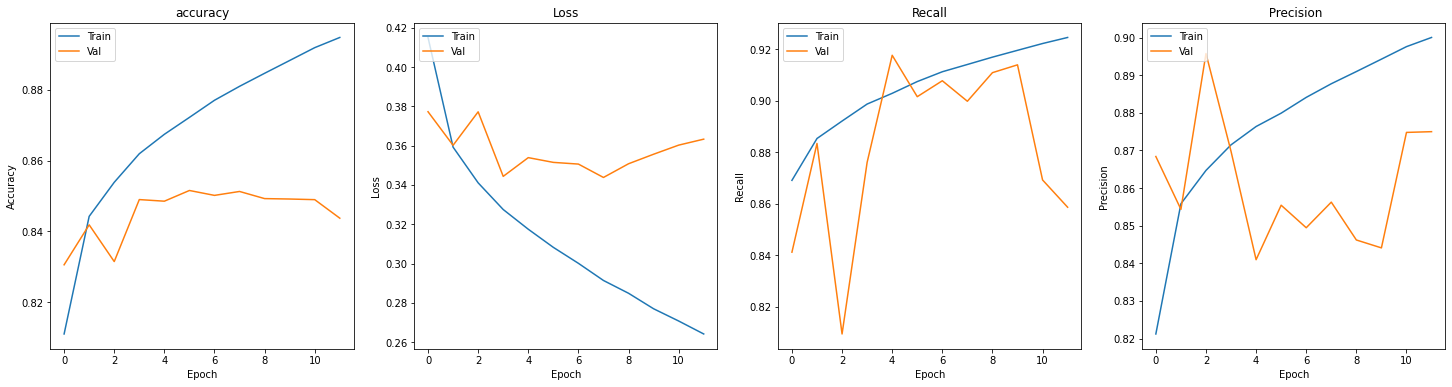

In [33]:
import matplotlib.pyplot as plt


plt.figure(figsize=(25, 6))
plt.subplot(1, 4, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(1, 4, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')

# plt.subplot(1, 4, 3)
# plt.plot(history.history[f'recall'])
# plt.plot(history.history[f'val_recall'])
# plt.title('Recall')
# plt.xlabel('Epoch')
# plt.ylabel('Recall')
# plt.legend(['Train', 'Val'], loc='upper left')

# plt.subplot(1, 4, 4)
# plt.plot(history.history[f'precision'])
# plt.plot(history.history[f'val_precision'])
# plt.title(' Precision')
# plt.xlabel('Epoch')
# plt.ylabel('Precision')
# plt.legend(['Train', 'Val'], loc='upper left')

num = 3
plt.subplot(1, 4, 3)
plt.plot(history.history[f'recall_{num}'])
plt.plot(history.history[f'val_recall_{num}'])
plt.title('Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(1, 4, 4)
plt.plot(history.history[f'precision_{num}'])
plt.plot(history.history[f'val_precision_{num}'])
plt.title(' Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Train', 'Val'], loc='upper left')

plt.savefig(f'./result/gru/f{min_freq}_l{max_len}_ft{embedding_size}_h{hidden_size}/alrp.png')

# 5. 평가

In [34]:
from tensorflow.keras.models import load_model


loaded_model = load_model(f'./result/gru/f{min_freq}_l{max_len}_ft{embedding_size}_h{hidden_size}/best_model.h5')

In [35]:
evaluate_list = loaded_model.evaluate(X_test, y_test)
print("\n 테스트 정확도: %.4f" % evaluate_list[1])

1976/1976 [==============================] - 12s 6ms/step - loss: 0.3532 - acc: 0.8496 - recall_3: 0.9004 - precision_3: 0.8544

 테스트 정확도: 0.8496


In [ ]:
for eval in evaluate_list:
    print("\n 평과 결과 리스트 ?: %.4f" % eval)

In [ ]:
def predict_text(tokenized_reviews):
    # 정수 인코딩
    encoded_reviews = tokenizer.texts_to_sequences(tokenized_reviews)

    # 패딩
    padded_reviews = pad_sequences(encoded_reviews, maxlen = max_len)
    
    # 예측
    scores = loaded_model.predict(padded_reviews)
                                  
    return scores

In [ ]:
test_data['score'] = predict_text(test_data['tokenized'])
test_data['predict'] = [1 if score > 0.5 else 0 for score in test_data['score']]
test_data['score'] = test_data['score'].apply(lambda x: int(x * 100) if x > 0.5 else int((1 - x) * 100))

In [ ]:
_test_data = test_data[['lael', 'predict','rating','score', 'review','tokenized']]

In [ ]:
positiveg_data = _test_data[_test_data['label'] == 1]
positive_wrong_data = positiveg_data[positiveg_data['predict'] == 0]
print(positive_wrong_data.head(5))

negative_data = _test_data[_test_data['label'] == 0]
negative_wrong_data = negative_data[negative_data['predict'] == 1]
print(negative_wrong_data.head(5))

In [ ]:
positive_wrong_data.to_csv(f'./result/gru/f{min_freq}_l{max_len}_e{embedding_size}_h{hidden_size}/positive_wrong_data.csv', index=False)
negative_wrong_data.to_csv(f'./result/gru/f{min_freq}_l{max_len}_e{embedding_size}_h{hidden_size}/negative_wrong_data.csv', index=False)